# Build the manually-labeled test set

In [1]:
# Import the librairies
import os, io
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import colors, colorbar
from matplotlib.colors import LinearSegmentedColormap
import colorsys
from PIL import Image

from urllib.request import urlopen, Request
from pathlib import Path
from hashlib import md5
import shutil

import bambird

# Update matplotlib default font size
# plt.rcParams.update({'font.size': 23})

In [2]:
def plot_distribution(df, data: str):
    # Get the unique categories
    categories = df.categories.unique()
    distribution = [len(df[df.categories == i]) for i in categories]
    fig, ax = plt.subplots(figsize=(30,5))
    ax.set_title('Distribution of {} for {} species'.format(data, len(categories)), size=15)
    ax.bar(np.arange(len(categories)), distribution, label='Total number of {}: {}'.format(data, len(df.index)))
    ax.set_xticks(np.arange(len(categories)))
    ax.set_xticklabels(list(categories))
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    plt.ylabel('Number of {}'.format(data))
    plt.legend()
    
def plot_rois(df, data: str):
    df_signal = df[df.manual_label == 1.0]
    # Get the unique categories
    signal = df_signal.species.unique()
    noise = df.species.unique() # keep only scientific species name for plot
    distribution_signal = [len(df_signal[df_signal.species == i]) for i in signal]
    distribution_noise = [len(df[df.species == i]) for i in noise]
    
    sig = {}
    for key in signal:
        for value in distribution_signal:
            sig[key] = value
            
    fig, ax = plt.subplots(figsize=(30,10))
    ax.set_title('Distribution of {} for {} species'.format(data, len(noise)), size=15)
    ax.bar(np.arange(len(noise)), np.sort(distribution_noise), color='black', 
           label='Noise: {} {}'.format(len(df.index)-len(df_signal.index), data))
    ax.bar(np.arange(len(signal)), np.sort(distribution_signal), color='grey', 
           label='Signal: {} {}'.format(len(df_signal.index), data))
    ax.set_xticks(np.arange(len(noise)))
    ax.set_xticklabels([i.rsplit("_")[0] for i in sorted(sig)]) # keep only scientific species name for plot
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    plt.ylabel('Number of {}'.format(data))
    plt.legend()
    plt.savefig('rois.png', dpi=300, bbox_inches="tight")

### Define constants and query Xeno-Canto database

In [3]:
# Temporary saved directory
TEMP_DIR        = "test"
DATASET_NAME    = Path('species')
ROIS_NAME       = Path('rois')
# Select the configuration file
CONFIG_FILE     = 'config.yaml'
params          = bambird.load_config(CONFIG_FILE)

# Select the crepuscular and nocturnal tropical bird target species
TARGET_SPECIES = [
                  # TINAMOUS
                  'Tinamus major', 
                  'Crypturellus cinereus',
                  'Crypturellus soui',
                  'Crypturellus variegatus',
                  'Crypturellus brevirostris',
                  # POTOOS
                  'Nyctibius bracteatus',
                  'Nyctibius grandis',
                  'Nyctibius aethereus',
                  'Nyctibius griseus',
                  'Nyctibius leucopterus',                       
                  # FALCONS
                  'Micrastur ruficollis',
                  'Micrastur gilvicollis',
                  'Micrastur mirandollei',
                  'Micrastur semitorquatus', 
                  # OWLS
                  'Megascops roraimae',
                  'Megascops watsonii', 
                  'Lophostrix cristata',
                  'Pulsatrix perspicillata',
                  'Strix virgata',
                  'Strix huhula',
                  'Glaucidium hardyi',
                  # NIGHTJARS
                  'Lurocalis semitorquatus',
                  'Hydropsalis maculicaudus',
                  'Hydropsalis cayennensis',
                  'Nyctiprogne leucopyga',
                  'Chordeiles acutipennis', 
                  'Chordeiles nacunda',
                  'Nyctipolus nigrescens',
                  'Nyctidromus albicollis',
                  'Hydropsalis climacocerca',    
                  ]

# Query Xeno-Canto database
df_dataset = bambird.query_xc(
                    species_list    = TARGET_SPECIES,
                    params          = params['PARAMS_XC'],
                    random_seed     = params['RANDOM_SEED'],
                    verbose         = False)

print(f'Initial number of target species for query: {len(TARGET_SPECIES)}')
print(f'Number of target species found for the query: {len(df_dataset.en.unique())}')

Initial number of target species for query: 30
Number of target species found for the query: 30


### Visualize the distribution of the audio recordings of the target species

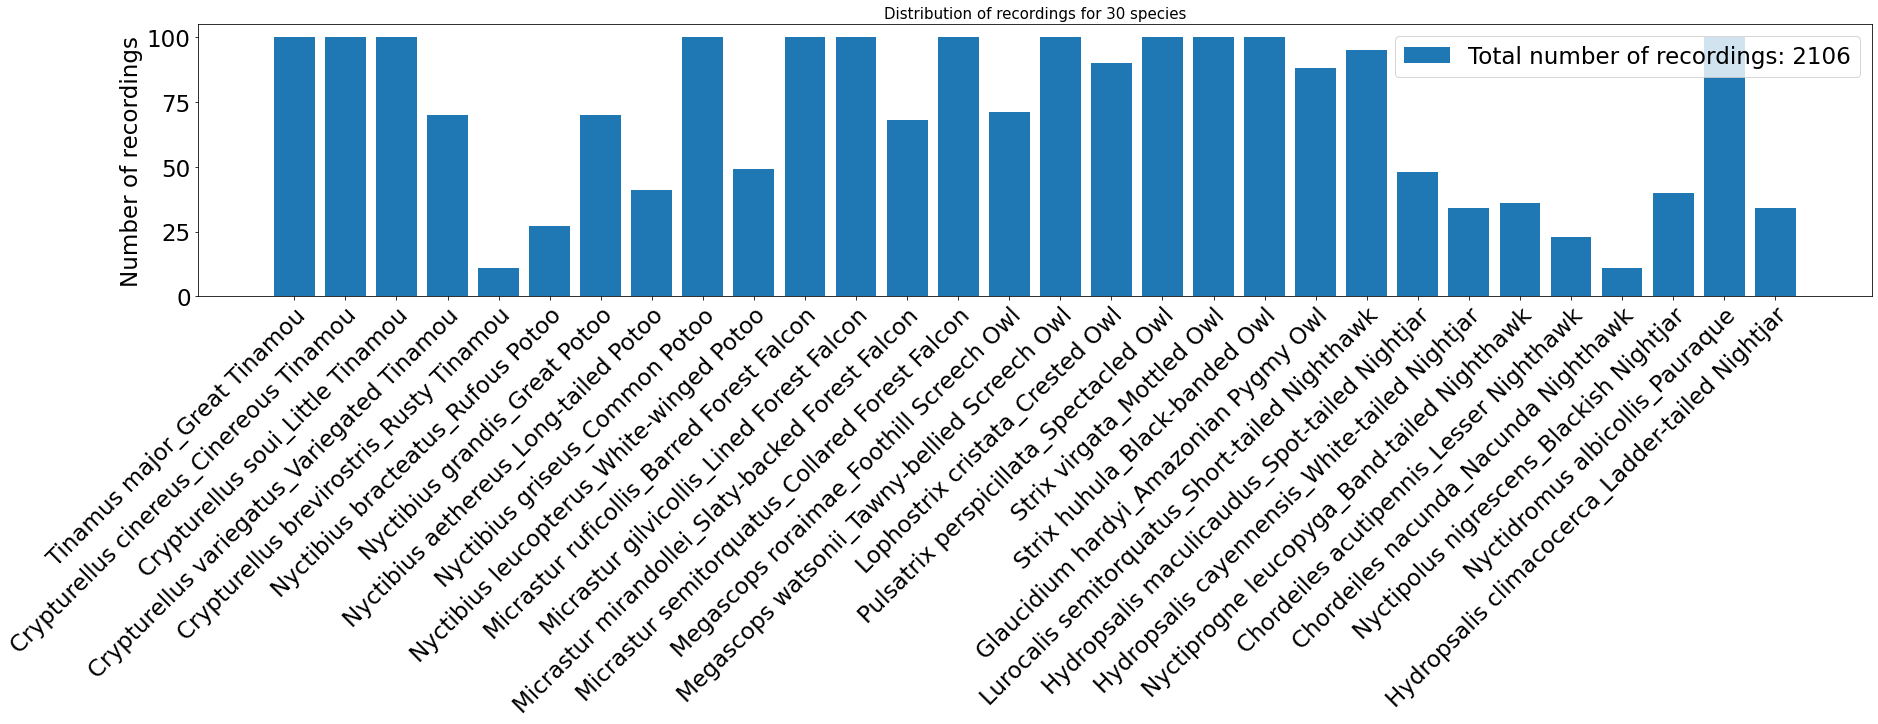

In [4]:
# df_dataset = pd.read_csv("docs/csv/xc_metadata.csv", sep=';')
plot_distribution(df_dataset, 'recordings')

### Plot the geographical distribution on the target species

Number of labels: 30


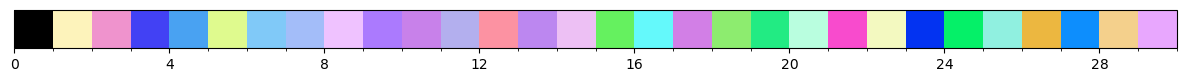

In [5]:
def rand_cmap(nlabels, type='bright', first_color_black=True, last_color_black=False, verbose=True):
    """
    Creates a random colormap to be used together with matplotlib. Useful for segmentation tasks
    :param nlabels: Number of labels (size of colormap)
    :param type: 'bright' for strong colors, 'soft' for pastel colors
    :param first_color_black: Option to use first color as black, True or False
    :param last_color_black: Option to use last color as black, True or False
    :param verbose: Prints the number of labels and shows the colormap. True or False
    :return: colormap for matplotlib
    """
    if type not in ('bright', 'soft'):
        print ('Please choose "bright" or "soft" for type')
        return

    if verbose:
        print('Number of labels: ' + str(nlabels))

    # Generate color map for bright colors, based on hsv
    if type == 'bright':
        randHSVcolors = [(np.random.uniform(low=0.0, high=1),
                          np.random.uniform(low=0.2, high=1),
                          np.random.uniform(low=0.9, high=1)) for i in range(nlabels)]

        # Convert HSV list to RGB
        randRGBcolors = []
        for HSVcolor in randHSVcolors:
            randRGBcolors.append(colorsys.hsv_to_rgb(HSVcolor[0], HSVcolor[1], HSVcolor[2]))

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]

        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Generate soft pastel colors, by limiting the RGB spectrum
    if type == 'soft':
        low = 0.6
        high = 0.95
        randRGBcolors = [(np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high)) for i in range(nlabels)]

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]
        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Display colorbar
    if verbose:
        fig, ax = plt.subplots(1, 1, figsize=(15, 0.5))

        bounds = np.linspace(0, nlabels, nlabels + 1)
        norm = colors.BoundaryNorm(bounds, nlabels)

        cb = colorbar.ColorbarBase(ax, cmap=random_colormap, norm=norm, spacing='proportional', ticks=None,
                                   boundaries=bounds, format='%1i', orientation=u'horizontal')

    return random_colormap

new_cmap = rand_cmap(30, type='bright', first_color_black=True, last_color_black=False, verbose=True)

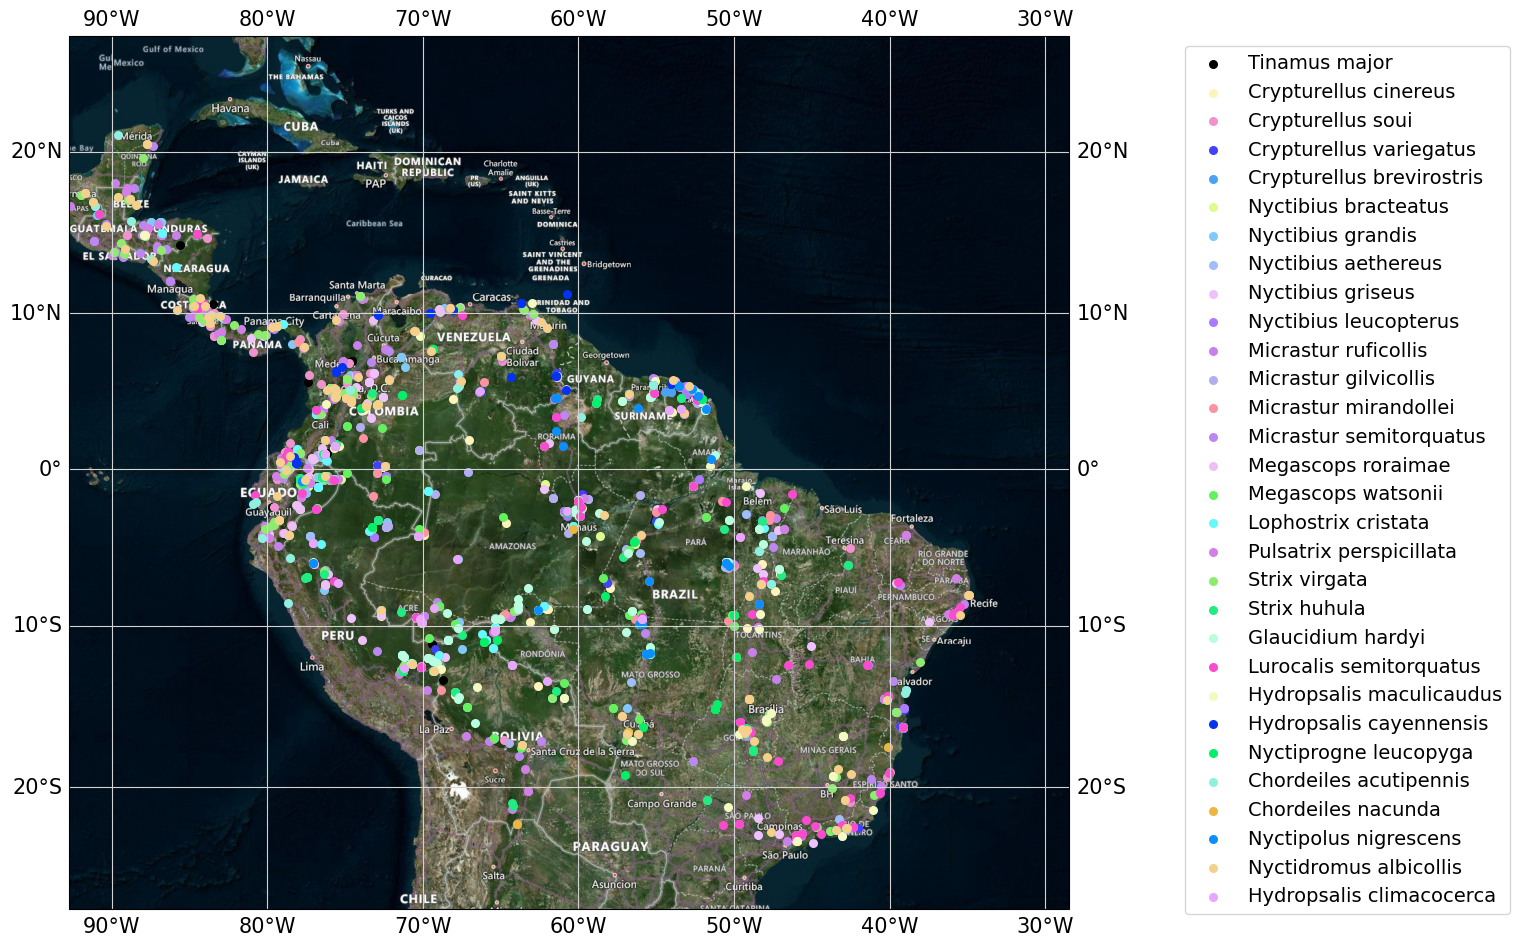

In [6]:
#!pip install cartopy
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

def plot_basemap(style = 'satellite', extent = [-100, -100, 100, 100], scale = 5):
    '''Download and plot an Open Street Map or Satellite base map
    lon: central longitude
    lat: central latitude
    style: either 'osm' or 'satellite'
    extent: the map limits in meters away from (lat, lon) [left, bottom, right, top]
    scale: if not None, used to select the map scale
    '''    
    # set up satellite map
    cimgt.QuadtreeTiles.get_image = image_spoof # reformat web request for street map spoofing
    img = cimgt.QuadtreeTiles() 

    # set up plot figure
    fig = plt.figure(figsize=(10,10)) # open matplotlib figure
    ax = fig.add_axes([0,0,1,1],projection=img.crs) # project using coordinate reference system (CRS) of street map
    
    # add image to plot
    ax.set_extent(extent) # set extents
    ax.add_image(img, int(scale)) # add OSM with zoom specification
    ax.gridlines(color='lightgrey', linestyle='-', draw_labels=True)
    
    return fig, ax

def image_spoof(self, tile):
    '''this function reformats web requests from OSM for cartopy
    Heavily based on code by Joshua Hrisko at:
        https://makersportal.com/blog/2020/4/24/geographic-visualizations-in-python-with-cartopy'''

    url = self._image_url(tile)                # get the url of the street map API
    req = Request(url)                         # start request
    req.add_header('User-agent','Anaconda 3')  # add user agent to request
    fh = urlopen(req) 
    im_data = io.BytesIO(fh.read())            # get image
    fh.close()                                 # close url
    img = Image.open(im_data)                  # open image with PIL
    img = img.convert(self.desired_tile_form)  # set image format
    return img, self.tileextent(tile), 'lower' # reformat for cartopy

fig, ax = plot_basemap(style='satellite', extent=[-28.439,-92.734,23.439,-23.789], scale=5)

# Combine two columns
df_dataset['species'] = df_dataset['gen'].astype(str) + ' ' + df_dataset['sp'].astype(str)
species = df_dataset["species"].unique().tolist()
plt.rcParams.update({'font.size': 15})

for i in np.arange(30):
    ax.scatter(df_dataset[df_dataset["species"] == species[i]]["lng"],
               df_dataset[df_dataset["species"] == species[i]]["lat"],
               transform=ccrs.PlateCarree(),
               c=new_cmap(i), s=30,
               label=species[i])

lgd = ax.legend(bbox_to_anchor=(1.45, 1), loc='best', fontsize=14)
# fig.savefig('map.jpg', dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight');

### Download audio files from the Xeno-Canto database

In [5]:
df_xc, csv_xc = bambird.download_xc(
                    df_dataset      = df_dataset,
                    rootdir         = TEMP_DIR, 
                    dataset_name    = DATASET_NAME, 
                    csv_filename    = params['PARAMS_XC']['CSV_XC_FILE'],
                    overwrite       = True,
                    verbose         = False)

### Extract region of interests (ROIs) and find the clusters

In [6]:
# Extract the ROIS of the full dataset
df_rois, csv_rois = bambird.multicpu_extract_rois(
                        dataset     = df_xc,
                        params      = params['PARAMS_EXTRACT'],
                        save_path   = TEMP_DIR / ROIS_NAME,
                        overwrite   = True,
                        verbose     = False)
   
# Compute the features on the full dataset       
df_features, csv_features = bambird.multicpu_compute_features(
                        dataset     = df_rois,
                        params      = params['PARAMS_FEATURES'],
                        save_path   = TEMP_DIR / ROIS_NAME,
                        overwrite   = True,
                        verbose     = False)

# Cluster the features with DBSCAN
df_cluster, csv_cluster = bambird.find_cluster(
                            dataset = df_features,
                            params  = params['PARAMS_CLUSTER'],
                         save_path  = TEMP_DIR / ROIS_NAME,
                            display = False,
                            verbose = False)

100%|██████████| 20408/20408 [08:05<00:00, 42.03it/s] 


Correct error in dataframe for the `nycleu` class by changing the category name of the `Nyctiprogne leucopyga`

In [7]:
print(f'Number of categories before correction: {len(df_cluster.categories.unique())}')
for i in range(len(df_cluster.index)):
    cat = os.path.dirname(df_cluster.fullfilename_ts.iloc[i]).split(os.sep)[2].split()[0]
    if cat == 'Nyctiprogne':
        df_cluster.categories.iloc[i] = 'nyctip'  
print(f'Number of categories after correction: {len(df_cluster.categories.unique())}')

Number of categories before correction: 29
Number of categories after correction: 30


### Manually label each target species and visualize the distribution of the ROIs

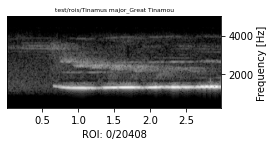

In [8]:
df_labels = bambird.label_rois(
                         df_cluster = df_rois, 
                         params     = params['PARAMS_EXTRACT'],
                         save_path  = TEMP_DIR / ROIS_NAME)

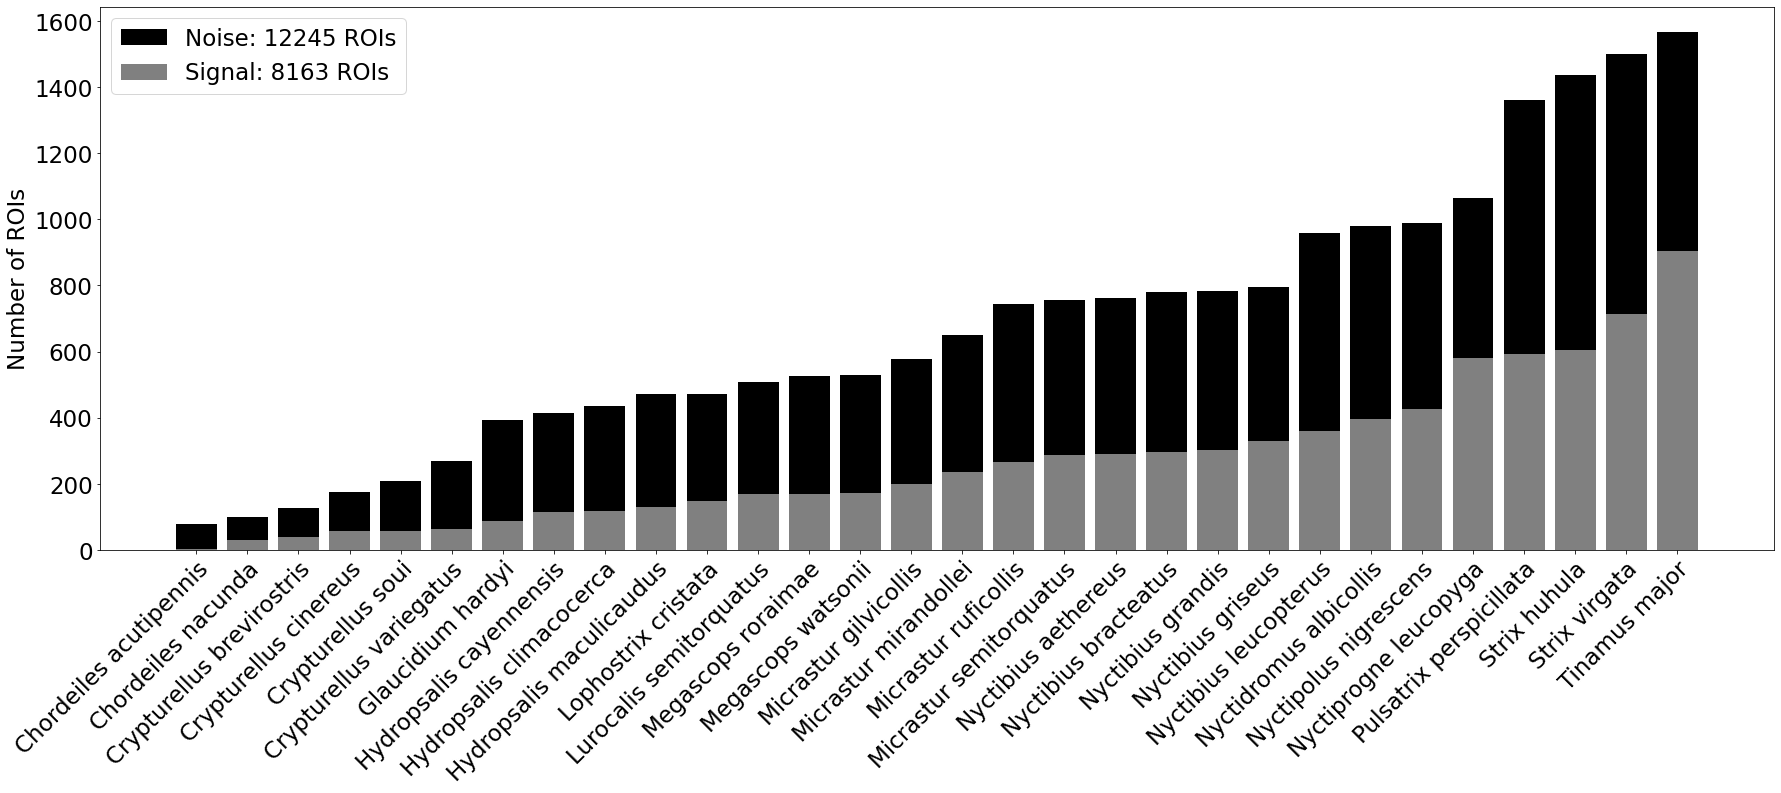

In [9]:
# df_labels = pd.read_csv('docs/csv/label.csv', sep=';')
plot_rois(df_labels, 'ROIs')

### Evaluate the pseudo labeling of ROIs

In [10]:
# df_cluster = pd.read_csv('docs/csv/cluster.csv', sep=';').set_index('filename_ts')
scores, p, r, f, marker = bambird.cluster_eval(df_cluster, df_labels, verbose=True)
scores

Initial number of ROIs is 126 / Final number of ROIs is 31 => 75.4% reduction / noise 75% => 100%  / recall 0% (choacu)
Initial number of ROIs is 79 / Final number of ROIs is 29 => 63.3% reduction / noise 95% => 100%  / recall 0% (chonac)
Initial number of ROIs is 99 / Final number of ROIs is 14 => 85.9% reduction / noise 59% => 0%  / recall 34% (crybre)
Initial number of ROIs is 1362 / Final number of ROIs is 964 => 29.2% reduction / noise 48% => 30%  / recall 95% (crycin)
Initial number of ROIs is 981 / Final number of ROIs is 611 => 37.7% reduction / noise 57% => 37%  / recall 91% (crysou)
Initial number of ROIs is 394 / Final number of ROIs is 167 => 57.6% reduction / noise 67% => 27%  / recall 94% (cryvar)
Initial number of ROIs is 1065 / Final number of ROIs is 805 => 24.4% reduction / noise 72% => 64%  / recall 95% (glahar)
Initial number of ROIs is 208 / Final number of ROIs is 148 => 28.8% reduction / noise 57% => 42%  / recall 97% (hydcay)
Initial number of ROIs is 175 / Fina

,number_rois_initial,number_rois_final,tp_initial,fp_initial,tp,fp,tn,fn,precision_initial,precision,recall
species,,,,,,,,,,,
choacu,126,31,31,95,0,31,64,31,25,0,0
chonac,79,29,4,75,0,29,46,4,5,0,0
crybre,99,14,41,58,14,0,58,27,41,100,34
crycin,1362,964,715,647,676,288,359,39,52,70,95
crysou,981,611,426,555,387,224,331,39,43,63,91
cryvar,394,167,130,264,122,45,219,8,33,73,94
glahar,1065,805,302,763,286,519,244,16,28,36,95
hydcay,208,148,89,119,86,62,57,3,43,58,97
hydcli,175,76,58,117,31,45,72,27,33,41,53


### Build the manually labeled test set in a new folder

In [11]:
# Create a directory
dataset_dir = 'test/test'
os.mkdir(dataset_dir)
# Create a copy of the positive ROIs dataframe
rois_positive = df_labels[df_labels.manual_label == 1.0]
df_darksound = rois_positive.reset_index().copy()

for i in df_darksound.species.unique():
    species = df_darksound[df_darksound.species == i].reset_index(drop=True)
    # Get the directory name of the category
    directory = os.path.dirname(species.fullfilename_ts.iloc[0]).split(os.sep)[-1]
    path = os.path.join(dataset_dir, directory)
    # Create a subdirectory for the species
    os.mkdir(path)
    # Copy all the files of the species in the subdirectory
    for index, row in species.iterrows():
        file_path = os.path.join(path, row.filename_ts)
        shutil.copy2(row.fullfilename_ts, file_path) 

Generate MD5 checksum of the zip file

In [12]:
m = md5()
with open("test/test.zip", "rb") as f:
    data = f.read()
    m.update(data)
    print(m.hexdigest())

00676bede612d3d7b8933ac03bc07a85
